In [42]:
import tarfile
import pathlib
import urllib

#Función para descargar los emails que se usarán como dataset de entrenamiento
def fetch_spam_data():
    spam_root = "http://spamassassin.apache.org/old/publiccorpus/"
    ham_url = spam_root + "20030228_easy_ham.tar.bz2"
    spam_url = spam_root + "20030228_spam.tar.bz2"

    spam_path = pathlib.Path() / "datasets" / "spam"
    spam_path.mkdir(parents=True, exist_ok=True)
    for dir_name, tar_name, url in (("easy_ham", "ham", ham_url),
                                    ("spam", "spam", spam_url)):
        if not (spam_path / dir_name).is_dir():
            path = (spam_path / tar_name).with_suffix(".tar.bz2")
            print("Downloading", path)
            urllib.request.urlretrieve(url, path)
            tar_bz2_file = tarfile.open(path)
            tar_bz2_file.extractall(path=spam_path)
            tar_bz2_file.close()
    return [spam_path / dir_name for dir_name in ("easy_ham", "spam")]
ham_dir, spam_dir = fetch_spam_data()
#A continuación cargamos todos los emails
ham_filenames = [f for f in sorted(ham_dir.iterdir()) if len(f.name) > 20]
spam_filenames = [f for f in sorted(spam_dir.iterdir()) if len(f.name) > 20]
#Usando el módulo de correos electrónicos de Python, para analizarlos (maneja encabezados, codificación, etc)
import email
import email.policy

def load_email(filepath):
    with open(filepath, "rb") as f:
        return email.parser.BytesParser(policy=email.policy.default).parse(f)
ham_emails = [load_email(filepath) for filepath in ham_filenames]
spam_emails = [load_email(filepath) for filepath in spam_filenames]
#Imprimimos un ejemplo de ham
print(ham_emails[1].get_content().strip())
#Imprimimos un ejemplo de Spam
print(spam_emails[6].get_content().strip())
#Algunos correos electrónicos son en realidad de varias partes, con imágenes y archivos adjuntos. La siguiente función analiza los distintos tipos de estructuras que tenemos.
def get_email_structure(email):
    if isinstance(email, str):
        return email
    payload = email.get_payload()
    if isinstance(payload, list):
        multipart = ", ".join([get_email_structure(sub_email)
                               for sub_email in payload])
        return f"multipart({multipart})"
    else:
        return email.get_content_type()
from collections import Counter

def structures_counter(emails):
    structures = Counter()
    for email in emails:
        structure = get_email_structure(email)
        structures[structure] += 1
    return structures
structures_counter(ham_emails).most_common()
structures_counter(spam_emails).most_common()
#Ahora echemos un vistazo al encabezado del correo electrónico.
for header, value in spam_emails[0].items():
    print(header, ":", value)
spam_emails[0]["Subject"]
#Dividimos en un conjunto de entrenamiento y prueba.
import numpy as np
from sklearn.model_selection import train_test_split

X = np.array(ham_emails + spam_emails, dtype=object)
y = np.array([0] * len(ham_emails) + [1] * len(spam_emails))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42)
#La siguiente función deja el texto sin formato HTML
import re
from html import unescape

def html_to_plain_text(html):
    text = re.sub('<head.*?>.*?</head>', '', html, flags=re.M | re.S | re.I)
    text = re.sub('<a\s.*?>', ' HYPERLINK ', text, flags=re.M | re.S | re.I)
    text = re.sub('<.*?>', '', text, flags=re.M | re.S)
    text = re.sub(r'(\s*\n)+', '\n', text, flags=re.M | re.S)
    return unescape(text)
#Veamos si funciona, este es un spam HTML
html_spam_emails = [email for email in X_train[y_train==1]
                    if get_email_structure(email) == "text/html"]
sample_html_spam = html_spam_emails[7]
print(sample_html_spam.get_content().strip()[:1000], "...")
#Este es su resultado en texto plano
print(html_to_plain_text(sample_html_spam.get_content())[:1000], "...")
#La siguiente función toma un correo electrónico como entrada y devuelve el contenido en texto sea cual sea el formato.
def email_to_text(email):
    html = None
    for part in email.walk():
        ctype = part.get_content_type()
        if not ctype in ("text/plain", "text/html"):
            continue
        try:
            content = part.get_content()
        except: # en caso de encontrar problemas de codificación.
            content = str(part.get_payload())
        if ctype == "text/plain":
            return content
        else:
            html = content
    if html:
        return html_to_plain_text(html)
print(email_to_text(sample_html_spam)[:100], "...")
#Ahora agregamos las herramientas de lenguaje natural (NLTK)
import nltk

stemmer = nltk.PorterStemmer()
for word in ("Computations", "Computation", "Computing", "Computed", "Compute",
             "Compulsive"):
    print(word, "=>", stemmer.stem(word))
#Esta librería extrae el contenido de una url.
%pip install -q -U urlextract
import urlextract

url_extractor = urlextract.URLExtract()
some_text = "Will it detect github.com and https://youtu.be/7Pq-S557XQU?t=3m32s"
print(url_extractor.find_urls(some_text))

from sklearn.base import BaseEstimator, TransformerMixin

class EmailToWordCounterTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, strip_headers=True, lower_case=True,
                 remove_punctuation=True, replace_urls=True,
                 replace_numbers=True, stemming=True):
        self.strip_headers = strip_headers
        self.lower_case = lower_case
        self.remove_punctuation = remove_punctuation
        self.replace_urls = replace_urls
        self.replace_numbers = replace_numbers
        self.stemming = stemming
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X_transformed = []
        for email in X:
            text = email_to_text(email) or ""
            if self.lower_case:
                text = text.lower()
            if self.replace_urls and url_extractor is not None:
                urls = list(set(url_extractor.find_urls(text)))
                urls.sort(key=lambda url: len(url), reverse=True)
                for url in urls:
                    text = text.replace(url, " URL ")
            if self.replace_numbers:
                text = re.sub(r'\d+(?:\.\d*)?(?:[eE][+-]?\d+)?', 'NUMBER', text)
            if self.remove_punctuation:
                text = re.sub(r'\W+', ' ', text, flags=re.M)
            word_counts = Counter(text.split())
            if self.stemming and stemmer is not None:
                stemmed_word_counts = Counter()
                for word, count in word_counts.items():
                    stemmed_word = stemmer.stem(word)
                    stemmed_word_counts[stemmed_word] += count
                word_counts = stemmed_word_counts
            X_transformed.append(word_counts)
        return np.array(X_transformed)
#Probemos este transformados en algunos correos electrónicos
X_few = X_train[:3]
X_few_wordcounts = EmailToWordCounterTransformer().fit_transform(X_few)
X_few_wordcounts
from scipy.sparse import csr_matrix

class WordCounterToVectorTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, vocabulary_size=1000):
        self.vocabulary_size = vocabulary_size
    def fit(self, X, y=None):
        total_count = Counter()
        for word_count in X:
            for word, count in word_count.items():
                total_count[word] += min(count, 10)
        most_common = total_count.most_common()[:self.vocabulary_size]
        self.vocabulary_ = {word: index + 1
                            for index, (word, count) in enumerate(most_common)}
        return self
    def transform(self, X, y=None):
        rows = []
        cols = []
        data = []
        for row, word_count in enumerate(X):
            for word, count in word_count.items():
                rows.append(row)
                cols.append(self.vocabulary_.get(word, 0))
                data.append(count)
        return csr_matrix((data, (rows, cols)),
                          shape=(len(X), self.vocabulary_size + 1))
vocab_transformer = WordCounterToVectorTransformer(vocabulary_size=10)
X_few_vectors = vocab_transformer.fit_transform(X_few_wordcounts)
X_few_vectors
X_few_vectors.toarray()
vocab_transformer.vocabulary_
#Transformemos todo el conjunto de datos con las funciones previamente creadas
from sklearn.pipeline import Pipeline

preprocess_pipeline = Pipeline([
    ("email_to_wordcount", EmailToWordCounterTransformer()),
    ("wordcount_to_vector", WordCounterToVectorTransformer()),
])

X_train_transformed = preprocess_pipeline.fit_transform(X_train)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

log_clf = LogisticRegression(max_iter=1000, random_state=42)
score = cross_val_score(log_clf, X_train_transformed, y_train, cv=3)
score.mean()
from sklearn.metrics import precision_score, recall_score

X_test_transformed = preprocess_pipeline.transform(X_test)

log_clf.fit(X_train_transformed, y_train)

y_pred = log_clf.predict(X_test_transformed)

print(f"Precision: {precision_score(y_test, y_pred):.2%}")
print(f"Recall: {recall_score(y_test, y_pred):.2%}")
import joblib

# Guardar el modelo en un archivo
filename = 'modelo_log_class_spam.joblib'
joblib.dump(log_clf, filename)
#Cargamos el clasificador
loaded_model = joblib.load('modelo_log_class_spam.joblib')

<>:80: SyntaxWarning: invalid escape sequence '\s'
<>:80: SyntaxWarning: invalid escape sequence '\s'
/var/folders/4r/258hym592n3dj3lrhvdy09m80000gn/T/ipykernel_23343/1240258088.py:80: SyntaxWarning: invalid escape sequence '\s'
  text = re.sub('<a\s.*?>', ' HYPERLINK ', text, flags=re.M | re.S | re.I)


Martin A posted:
Tassos Papadopoulos, the Greek sculptor behind the plan, judged that the
 limestone of Mount Kerdylio, 70 miles east of Salonika and not far from the
 Mount Athos monastic community, was ideal for the patriotic sculpture. 
 
 As well as Alexander's granite features, 240 ft high and 170 ft wide, a
 museum, a restored amphitheatre and car park for admiring crowds are
planned
---------------------
So is this mountain limestone or granite?
If it's limestone, it'll weather pretty fast.

------------------------ Yahoo! Groups Sponsor ---------------------~-->
4 DVDs Free +s&p Join Now
http://us.click.yahoo.com/pt6YBB/NXiEAA/mG3HAA/7gSolB/TM
---------------------------------------------------------------------~->

To unsubscribe from this group, send an email to:
forteana-unsubscribe@egroups.com

 

Your use of Yahoo! Groups is subject to http://docs.yahoo.com/info/terms/
Help wanted.  We are a 14 year old fortune 500 company, that is
growing at a tremendous rate.  We are loo

New Precision: 100.00%
New Recall: 85.26%
New F1 Score: 92.05%
Best Threshold: None
Final Precision: 100.00%
Final Recall (Target ~85.0%): 85.26%
Final F1 Score: 92.05%


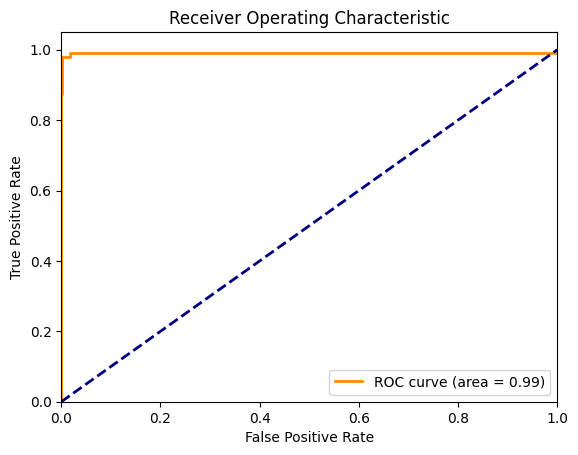

AUC: 98.91%


In [44]:
from sklearn.metrics import precision_score, recall_score, precision_recall_curve, f1_score, roc_curve, auc
import matplotlib.pyplot as plt

# Volvemos a cargar el modelo entrenado.
filename = 'modelo_log_class_spam.joblib'
log_clf = joblib.load(filename)

# Transformamos el conjunto de pruebas con el pipeline de preprocesamiento.
X_test_transformed = preprocess_pipeline.transform(X_test)

# Obtenemos las probabilidades de predicción en el set de pruebas.
y_scores = log_clf.predict_proba(X_test_transformed)[:, 1]

# Calculamos las curvas de precisión-recall.
precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores)

# Encontramos el umbral que nos da aproximadamente 85% de sensibilidad.
target_recall = 85.0 / 100  # 85%
closest_index = np.argmin(np.abs(recalls - target_recall))
optimal_threshold = thresholds[closest_index]

# Predicciones con el nuevo umbral.
y_pred_new_threshold = (y_scores >= optimal_threshold).astype(int)

# Calculamos y mostramos precisión y sensibilidad con el nuevo umbral.
precision_new_threshold = precision_score(y_test, y_pred_new_threshold)
recall_new_threshold = recall_score(y_test, y_pred_new_threshold)
f1_new_threshold = f1_score(y_test, y_pred_new_threshold)

print(f"New Precision: {precision_new_threshold:.2%}")
print(f"New Recall: {recall_new_threshold:.2%}")
print(f"New F1 Score: {f1_new_threshold:.2%}")

# Búsqueda refinada alrededor del umbral encontrado para ajustarnos al 85%
# Ajustamos un rango de búsqueda más fino para reducir precisión
adjustment_range = 100  # número de pasos de ajuste alrededor del umbral encontrado
step_size = 0.001  # tamaño del paso de ajuste

best_threshold = None
best_precision = precision_new_threshold
best_recall = recall_new_threshold
best_f1 = f1_new_threshold

for step in range(adjustment_range):
    adjusted_threshold = optimal_threshold - step * step_size
    if adjusted_threshold < 0:
        break
    y_pred_adjusted_threshold = (y_scores >= adjusted_threshold).astype(int)
    recall_adjusted = recall_score(y_test, y_pred_adjusted_threshold)
    precision_adjusted = precision_score(y_test, y_pred_adjusted_threshold)
    f1_adjusted = f1_score(y_test, y_pred_adjusted_threshold)
    if recall_adjusted >= 85.0 and recall_adjusted < 86.0 and precision_adjusted < precision_new_threshold:
        best_threshold = adjusted_threshold
        best_precision = precision_adjusted
        best_recall = recall_adjusted
        best_f1 = f1_adjusted
        break

# Imprimir los valores finales
print(f"Best Threshold: {best_threshold}")
print(f"Final Precision: {best_precision:.2%}")
print(f"Final Recall (Target ~85.0%): {best_recall:.2%}")
print(f"Final F1 Score: {best_f1:.2%}")

# Guardamos el modelo y el mejor umbral ajustado.
filename_with_best_threshold = 'modelo_log_class_spam_with_best_threshold.joblib'
joblib.dump((log_clf, best_threshold), filename_with_best_threshold)

# Calcular curva ROC y AUC
fpr, tpr, roc_thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# Visualización de la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Imprimir el área bajo la curva (AUC)
print(f'AUC: {roc_auc:.2%}')